### Violence Detection using CNN + LSTM neural network

#### Imports

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
import os
%cd '/content/gdrive/MyDrive/Practice Module/Violence-Detection'
pwd = os.getcwd()
print(pwd)

Mounted at /content/gdrive
/content/gdrive/MyDrive/Practice Module/Violence-Detection
/content/gdrive/MyDrive/Practice Module/Violence-Detection


In [11]:
%matplotlib inline
import cv2
import os
import glob
import random
import sys
import h5py
import numpy as np
import matplotlib.pyplot as plt
from random import shuffle
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.model_selection import KFold
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint,CSVLogger
from tensorflow.keras.applications import VGG16
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Input, LSTM
from tensorflow.keras.layers import Dense, Activation , Dropout


Load pre-processed data onto memory:

In [3]:
def process_data(h5_file):
    
    #joint_transfer=[]
    frames_num=100
    count = 0
    data, target = [], []

    with h5py.File(h5_file, 'r') as f:
            
        X_batch = f['data'][:]
        y_batch = f['labels'][:]

    for i in range(int(len(X_batch)/frames_num)):
        inc = count+frames_num
        data.append(X_batch[count:inc])
        target.append(y_batch[count])
        count =inc

    data, target = np.array(data), np.array(target)
            
    return data, target

In [5]:
x_train, y_train = process_data('datasets/lstm_rgb_train.h5')
x_val, y_val = process_data('datasets/lstm_rgb_test.h5')
print(x_train.shape, x_val.shape, y_train.shape, y_val.shape)

(1279, 100, 4096) (320, 100, 4096) (1279, 2) (320, 2)


In [6]:
x_test, y_test = process_data('datasets/lstm_rgb_val.h5')
print(x_test.shape, y_test.shape)

(400, 100, 4096) (400, 2)


### Define LSTM architecture

The first input dimension of LSTM neurons is the temporal dimension, in our case it is 100. The second is the size of the features vector (transfer values).


In [ ]:
chunk_size = 4096
n_chunks = 100
rnn_size = 512

model = Sequential()
model.add(LSTM(rnn_size, input_shape=(n_chunks, chunk_size)))
model.add(Dropout(0.5))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(50))
model.add(Activation('sigmoid'))
model.add(Dropout(0.5))
model.add(Dense(2))
model.add(Activation('sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

In [16]:
model = load_model('lstm_model.h5')
model_name = 'model_lstm_rgb_5fold'

#### Model training


In [17]:

folderpath      = pwd+'/'
filepath        = folderpath + model_name + "_weights.h5"
checkpoint      = ModelCheckpoint(filepath, 
                                  monitor='val_accuracy', 
                                  verbose=0, 
                                  save_best_only=True, 
                                  mode='max')

csv_logger      = CSVLogger(folderpath+model_name +'_history.csv')                       # Step 2
callbacks_list  = [checkpoint,csv_logger]                                       # Step 3

print("Callbacks created:")
print(callbacks_list[0])
print(callbacks_list[1])
print('')
print("Path to model:", filepath)
print("Path to log:  ", folderpath+model_name+'_history.csv')

Callbacks created:

Path to model: /content/gdrive/MyDrive/Practice Module/Violence-Detection/model_lstm_rgb_5fold_weights.h5
Path to log:   /content/gdrive/MyDrive/Practice Module/Violence-Detection/model_lstm_rgb_5fold_history.csv


In [18]:
epoch = 50
batch = 64
num_folds = 5
batch_size = 64
epochs = 50
verbosity = 0
# Merge inputs and targets
inputs = np.concatenate((x_train, x_val), axis=0)
targets = np.concatenate((y_train, y_val), axis=0)

# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
acc_per_fold, loss_per_fold = [], []
for train, val in kfold.split(inputs, targets):

    history = model.fit(inputs[train], targets[train], 
                        epochs=epochs,
                        validation_data=(inputs[val], targets[val]), 
                        batch_size=batch_size, 
                        verbose=verbosity,
                        callbacks=callbacks_list)
    
    # Generate generalization metrics
    scores = model.evaluate(inputs[val], targets[val], verbose=1)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    fold_no += 1

# Generate best scores
model.load_weights(filepath)
scores = model.evaluate(inputs[val], targets[val], verbose=1)
print(f'Best Score: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')

10/10 [==============================] - 1s 37ms/step - loss: 0.6431 - accuracy: 0.6219
Score for fold 1: loss of 0.6430652141571045; accuracy of 62.187498807907104%
10/10 [==============================] - 0s 32ms/step - loss: 0.5532 - accuracy: 0.7125
Score for fold 2: loss of 0.5531683564186096; accuracy of 71.24999761581421%
10/10 [==============================] - 0s 30ms/step - loss: 0.5587 - accuracy: 0.7437
Score for fold 3: loss of 0.5586656332015991; accuracy of 74.37499761581421%
10/10 [==============================] - 0s 30ms/step - loss: 0.4841 - accuracy: 0.7563
Score for fold 4: loss of 0.4840931296348572; accuracy of 75.62500238418579%
10/10 [==============================] - 0s 32ms/step - loss: 0.4964 - accuracy: 0.7712
Score for fold 5: loss of 0.4964466094970703; accuracy of 77.11598873138428%
10/10 [==============================] - 0s 32ms/step - loss: 0.4842 - accuracy: 0.7680
Best Score: loss of 0.4842393398284912; accuracy of 76.80251002311707%


#### Test the model

To test the model with x_test data. These videos have not been used to train the network. 

In [19]:
# Evaluate the deep learning model
y_pred = model.predict(np.array(x_test), verbose=0)
print("Confusion matrix")
print(confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))
print('Accuracy  :', accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))
print('Precision :', precision_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))
print('Recall    :', recall_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))

Confusion matrix
[[142  58]
 [ 61 139]]
Accuracy  : 0.7025
Precision : 0.7055837563451777
Recall    : 0.695


#### Plot the model accuracy

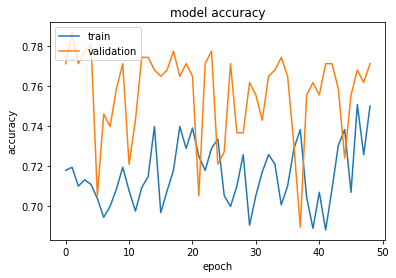

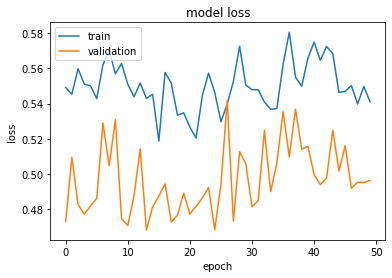

In [20]:
plt.plot(history.history['accuracy'][1:])
plt.plot(history.history['val_accuracy'][1:])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
#plt.savefig('rgb_lstm_acc.png')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
#plt.savefig('rgb_lstm_loss.png')
plt.show()

In [ ]:
import pandas as pd
df_history = pd.DataFrame(history.history)
df_history.to_csv('results/rgb_lstm_5fold_history.csv')